In [2]:
library(tidyverse)
library(Seurat)
library(ggthemes)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'spatstat.geom':
  method     from
  print.boxx cli 

Attaching SeuratObject



In [3]:
hires  <- readRDS("../hires_mouse_emb_dev.new.rds")

In [4]:
temp <- read_tsv(paste0("/shareb/zliu/analysis/hires_mouse_dev/HiC_clean3/3d_info/radialPos/GasaE751007.rp.50k.1.color"),col_names = FALSE)
names(temp) <- c("chrom","bin","pos")

Rows: 96358 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): X1
dbl (2): X2, X3

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
DefaultAssay(hires) <-"SCT"

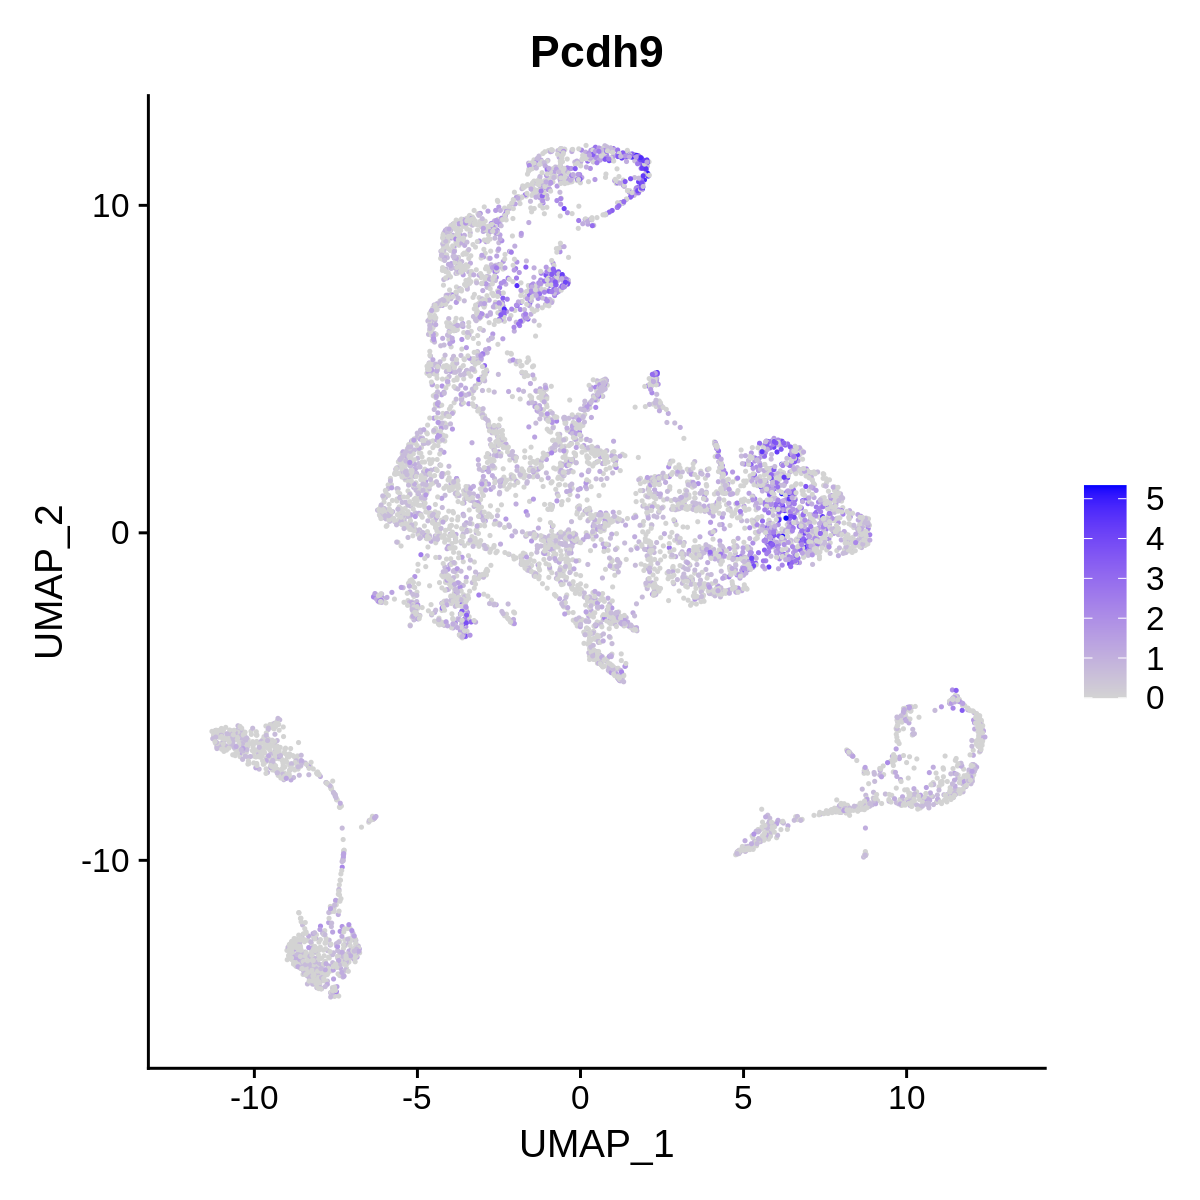

In [6]:
options(repr.plot.height=6,repr.plot.width=6,repr.plot.res = 200)

FeaturePlot(hires,"Pcdh9")

In [8]:
hires[[]] %>% filter(rmsd_20k < 1.5) %>% pull(cellname) %>% as.data.frame %>% write_tsv("cellnames.txt",col_names = FALSE)

In [7]:
set.seed(42)
c(hires[[]] %>% filter(celltype == "early neurons",rmsd_20k < 1.5) %>% sample_n(100) %>% pull(cellname),
hires[[]] %>% filter(celltype == "epiblast and PS",rmsd_20k < 1.5) %>% sample_n(100) %>% pull(cellname)) %>% as.data.frame() %>% write_tsv("cellnames.txt",col_names = FALSE)

In [9]:
cellnames_qcpass <- hires[[]] %>% filter(rmsd_20k < 1.5,celltype %in% c("early neurons", "epiblast and PS")) %>% pull(cellname)
color_paths <- paste0("/shareb/zliu/analysis/hires_mouse_dev/HiC_clean3/3d_info/radialPos/",cellnames_qcpass,".rp.20k.0.color")

In [10]:
celltypeColors = c(
"mitosis"="#bebebe","blood"="#ff9400",
"ExE endoderm"="#fec44f", "ExE ectoderm"="#cab2d6", 
"epiblast and PS"="#addd8e",
#neural
"neural ectoderm"="#AECBE6","NMP"="#96B9DB","neural tube"="#7EA8D0","notochord"="#6696C6","radial glias"="#4F85BB","oligodendrocytes and progenitors"="#3773B1","schwann cell precursors"="#08519C","early neurons"="#1F62A6",
#mesodermal
"early mesoderm"="#FC9272","ExE mesoderm"="#EF7F64","early mesenchyme"="#E36C57","intermediate mesoderm"="#D6594A", "myocytes"="#CA473C","mix late mesenchyme"="#BD342F",
"endoderm"="#fe9929","epithelial cells"="#fa9fb5"
)
cellcyclecolors = c("G0"="#762a83","G1"="#c2a5cf","Early-S"="#99d8c9","Mid-S"="#66c2a4","Late-S"="#41ae76","G2"="#238b45","M"="#ea6e34")

In [35]:
color_paths <- paste0("/shareb/zliu/analysis/hires_mouse_dev/HiC_clean3/3d_info/radialPos/",cellnames_qcpass,".rp.20k.0.color")
parseRadPos <- function(filename){
    temp <- read_table(filename,col_types = cols(),col_names = c("chr","bin","pos")) %>% mutate(cellname = str_extract(filename,"[GO][A-Za-z]+[0-9]+"), rep = strsplit(filename,".",fixed=TRUE)[[1]][5])
    return(temp)
}
res <- map(color_paths,parseRadPos) %>% bind_rows()
res <- res %>% group_by(cellname) %>% mutate(pos_norm = pos/mean(pos))
data <- res %>% left_join(hires[[]] %>% select(cellname,celltype)) %>% group_by(celltype,chr,bin) %>% summarise(mean_pos = mean(pos_norm))

# exclude chrom XY 
all <- data %>% mutate(chrom = str_extract(chr,pattern = "chr[0-9]+")) %>% group_by(celltype,chrom,bin) %>% summarise(mean_pos = mean(mean_pos)) %>% na.omit()
all$chrom <- factor(all$chrom, levels = paste0("chr",seq(1:19)))
all$celltype <- factor(all$celltype, levels =names(celltypeColors))

Joining, by = "cellname"
`summarise()` has grouped output by 'celltype', 'chr'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'celltype', 'chrom'. You can override using
the `.groups` argument.


In [36]:
all <- data %>% mutate(chrom = str_extract(chr,pattern = "chr[0-9]+"),allele = str_extract(chr,pattern = "[pm]at")) %>% group_by(celltype,chrom,allele,bin) %>% summarise(mean_pos = mean(mean_pos)) %>% na.omit()
all$chrom <- factor(all$chrom, levels = paste0("chr",seq(1:19)))
all$celltype <- factor(all$celltype, levels =names(celltypeColors))

`summarise()` has grouped output by 'celltype', 'chrom', 'allele'. You can
override using the `.groups` argument.


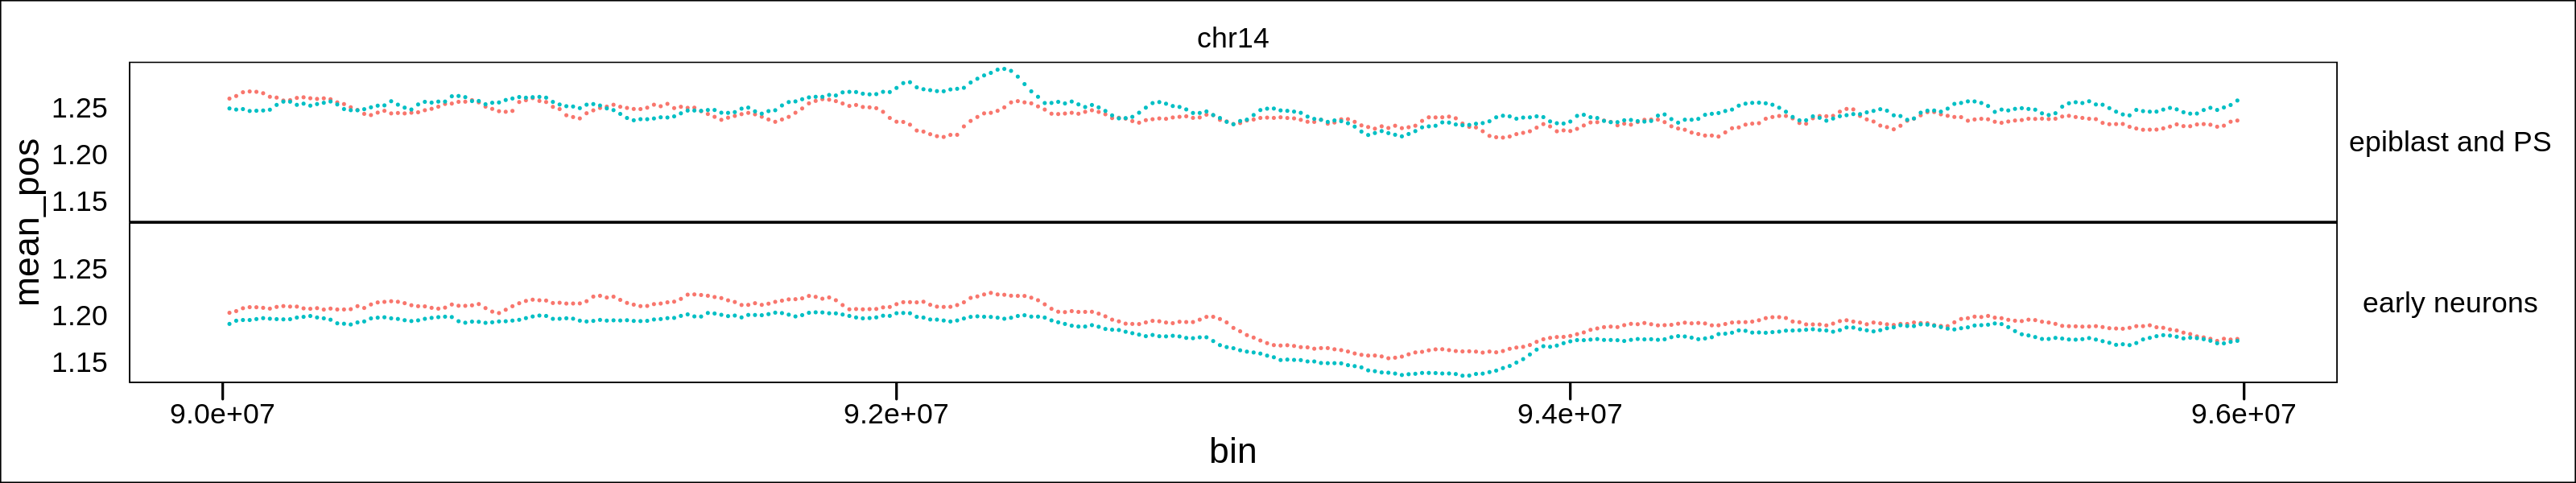

In [37]:
options(repr.plot.width=16, repr.plot.height=3,repr.plot.res=200)
all%>% filter(chrom == "chr14",bin > 90000000 ,bin < 96000000) %>% ggplot(aes(x=bin,y=mean_pos,color = allele)) + geom_point(size = 0.2) + facet_grid(celltype~chrom,scales = "free_x",space = "free") + 
    theme_base() +theme(#axis.text.x = element_blank(),axis.text.y = element_blank(),
    #axis.ticks.x = element_blank(),
    axis.ticks.y = element_blank(), panel.spacing=unit(0,"lines"),
    strip.text.y = element_text(angle = 0))+ NoLegend() #+ scale_colour_manual(name="",  values =celltypeColors) + NoLegend()


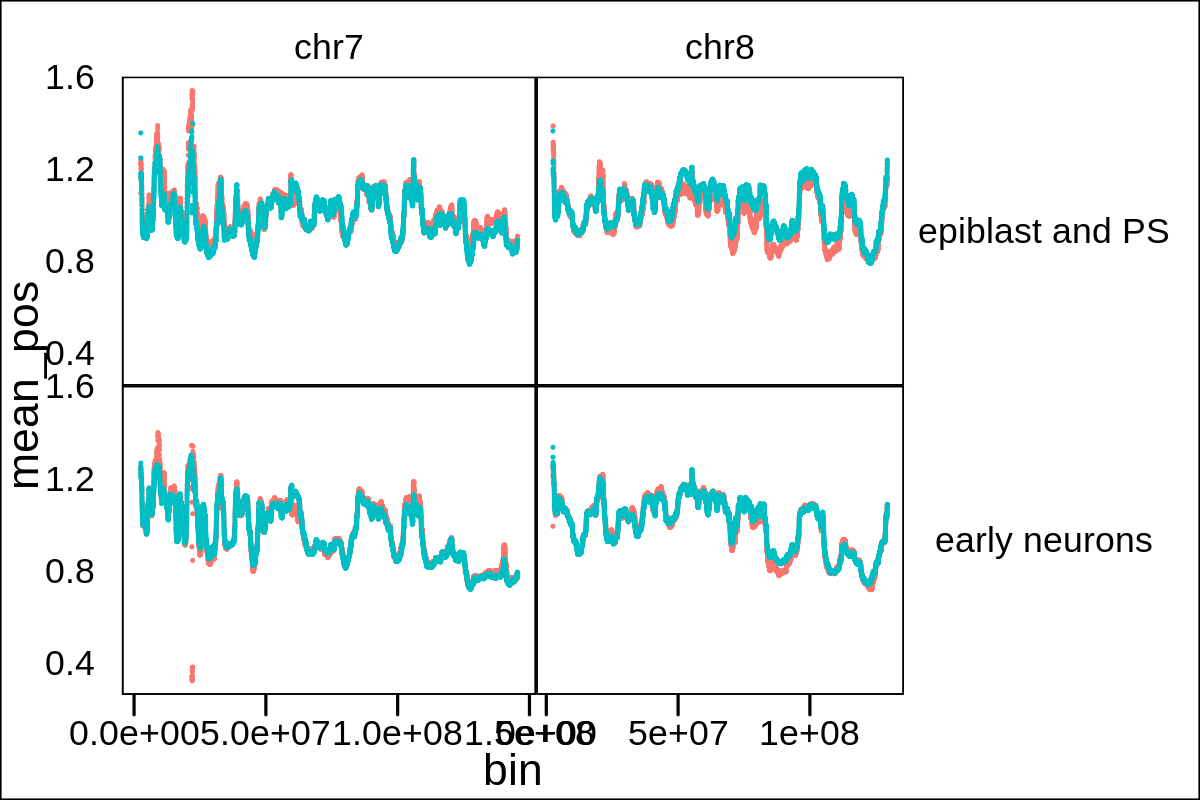

In [38]:
options(repr.plot.width=6, repr.plot.height=4,repr.plot.res=200)
all%>% filter(chrom %in% c("chr7","chr8")) %>% ggplot(aes(x=bin,y=mean_pos,color = allele)) + geom_point(size = 0.2) + facet_grid(celltype~chrom,scales = "free_x",space = "free") + 
    theme_base() +theme(#axis.text.x = element_blank(),axis.text.y = element_blank(),
    #axis.ticks.x = element_blank(),
    axis.ticks.y = element_blank(), panel.spacing=unit(0,"lines"),
    strip.text.y = element_text(angle = 0))+ NoLegend() 

In [48]:
files <- dir("/shareb/zliu/analysis/hires_validation/Tan2021/HiC/radialpos/20k/")
Tancolor_paths <- paste0("/shareb/zliu/analysis/hires_validation/Tan2021/HiC/radialpos/20k/",files[str_detect(files,"bc")])

In [49]:
res <- map(Tancolor_paths,parseRadPos) %>% bind_rows()
res <- res %>% group_by(cellname) %>% mutate(pos_norm = pos/mean(pos))
data <- res %>% mutate(celltype = "neuron") %>% group_by(celltype,chr,bin) %>% summarise(mean_pos = mean(pos_norm))

# exclude chrom XY 
all <- data %>% mutate(chrom = str_extract(chr,pattern = "chr[0-9]+"),allele = str_extract(chr,pattern = "[pm]at")) %>% group_by(celltype,chrom,allele,bin) %>% summarise(mean_pos = mean(mean_pos)) %>% na.omit()
all$chrom <- factor(all$chrom, levels = paste0("chr",seq(1:19)))
#all$celltype <- factor(all$celltype, levels =names(celltypeColors))

`summarise()` has grouped output by 'celltype', 'chr'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'celltype', 'chrom', 'allele'. You can
override using the `.groups` argument.


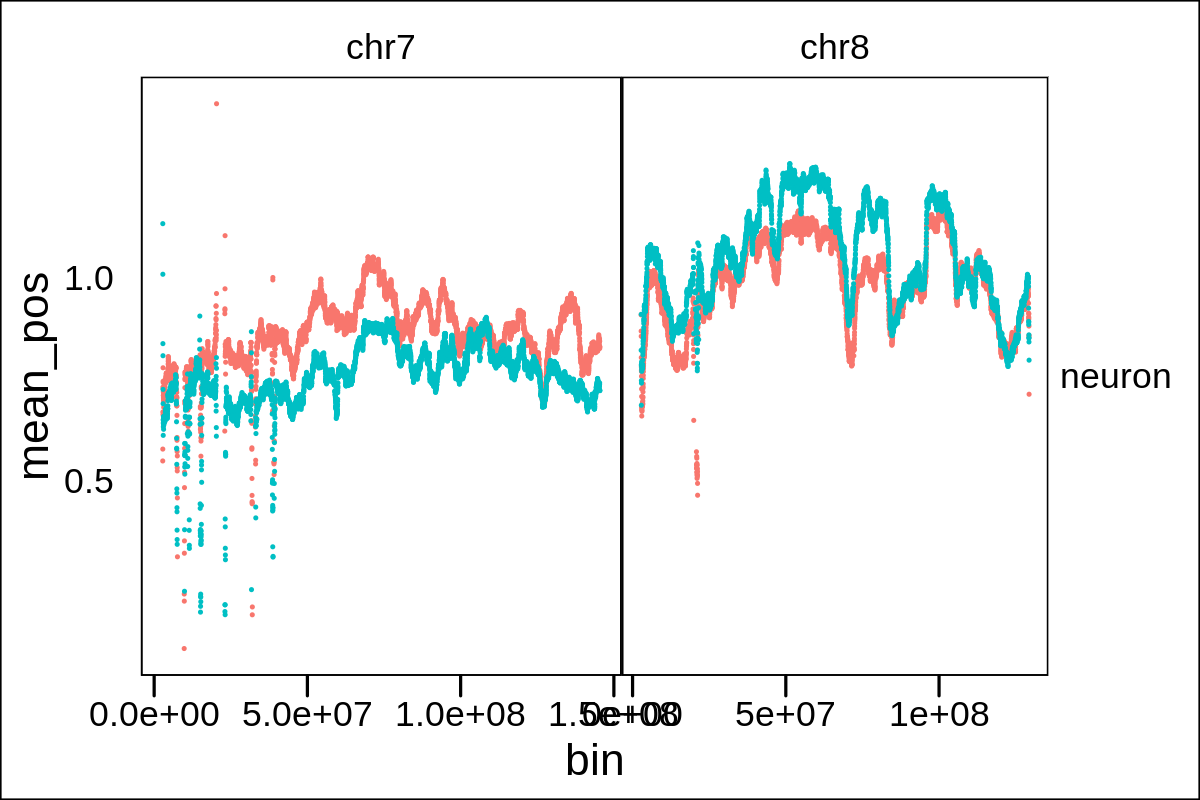

In [50]:
options(repr.plot.width=6, repr.plot.height=4,repr.plot.res=200)
all%>% filter(chrom %in% c("chr7","chr8")) %>% ggplot(aes(x=bin,y=mean_pos,color = allele)) + geom_point(size = 0.2) + facet_grid(celltype~chrom,scales = "free_x",space = "free") + 
    theme_base() +theme(#axis.text.x = element_blank(),axis.text.y = element_blank(),
    #axis.ticks.x = element_blank(),
    axis.ticks.y = element_blank(), panel.spacing=unit(0,"lines"),
    strip.text.y = element_text(angle = 0))+ NoLegend() 

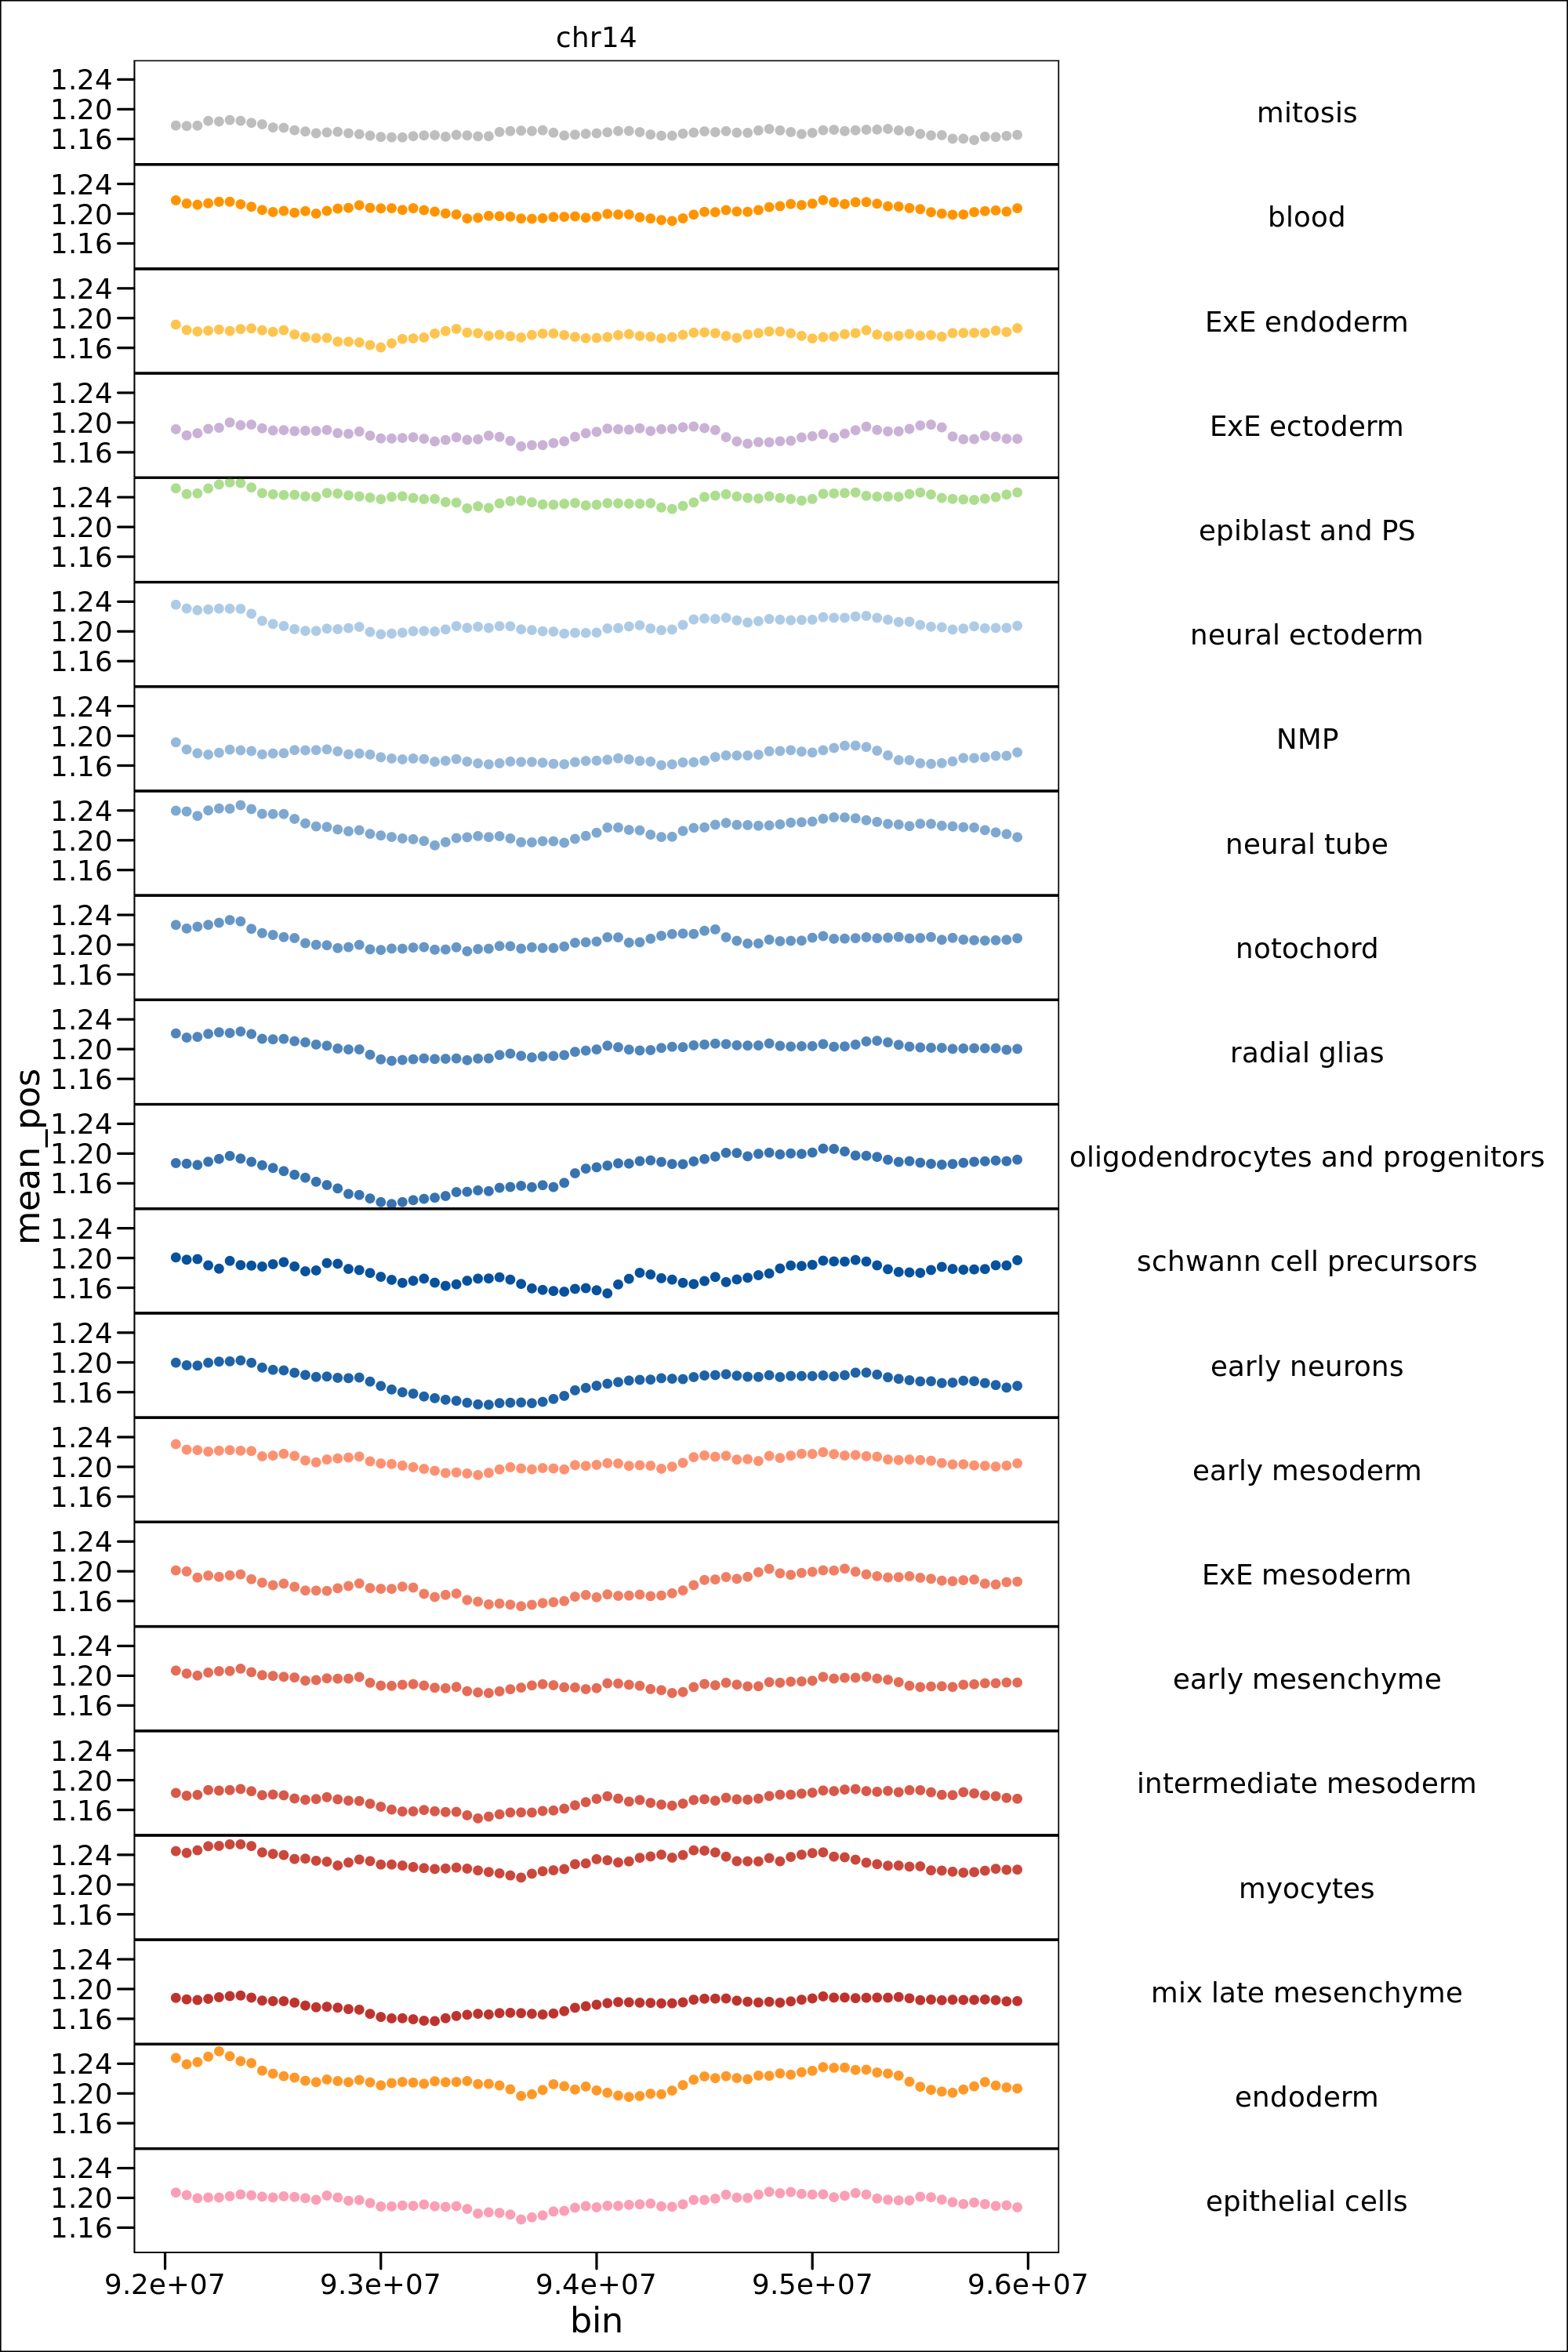

In [86]:
options(repr.plot.width=10, repr.plot.height=15,repr.plot.res=200)
all %>% filter(chrom =="chr14",bin > 92000000,bin < 96000000) %>% ggplot(aes(x=bin,y=mean_pos,color = celltype)) + geom_point() + facet_grid(celltype~chrom,scales = "free_x",space = "free") + 
    theme_base() + 
    theme(#axis.text.x = element_blank(),axis.text.y = element_blank(),
    #axis.ticks.x = element_blank(),
    #axis.ticks.y = element_blank(), 
                        panel.spacing=unit(0,"lines"),
    strip.text.y = element_text(angle = 0)) + scale_colour_manual(name="",  values =celltypeColors) + NoLegend()

In [103]:
library(ggpubr)

In [ ]:
#seems work, what about rank nomalize?

## Rank Normalize radial position

In [97]:
res <- map(color_paths,parseRadPos) %>% bind_rows()
#res <- res %>% group_by(cellname) %>% mutate(pos_norm = rank(pos)/n())
res <- res %>% group_by(cellname) %>% mutate(pos_norm = scale(pos))

In [98]:
data <- res %>% left_join(hires[[]] %>% select(cellname,celltype)) %>% group_by(celltype,chr,bin) %>% summarise(mean_pos = mean(pos_norm))
# exclude chrom XY 
all <- data %>% mutate(chrom = str_extract(chr,pattern = "chr[0-9]+")) %>% group_by(celltype,chrom,bin) %>% summarise(mean_pos = mean(mean_pos)) %>% na.omit()
all$chrom <- factor(all$chrom, levels = paste0("chr",seq(1:19)))
all$celltype <- factor(all$celltype, levels =names(celltypeColors))

Joining, by = "cellname"
`summarise()` has grouped output by 'celltype', 'chr'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'celltype', 'chrom'. You can override using the `.groups` argument.


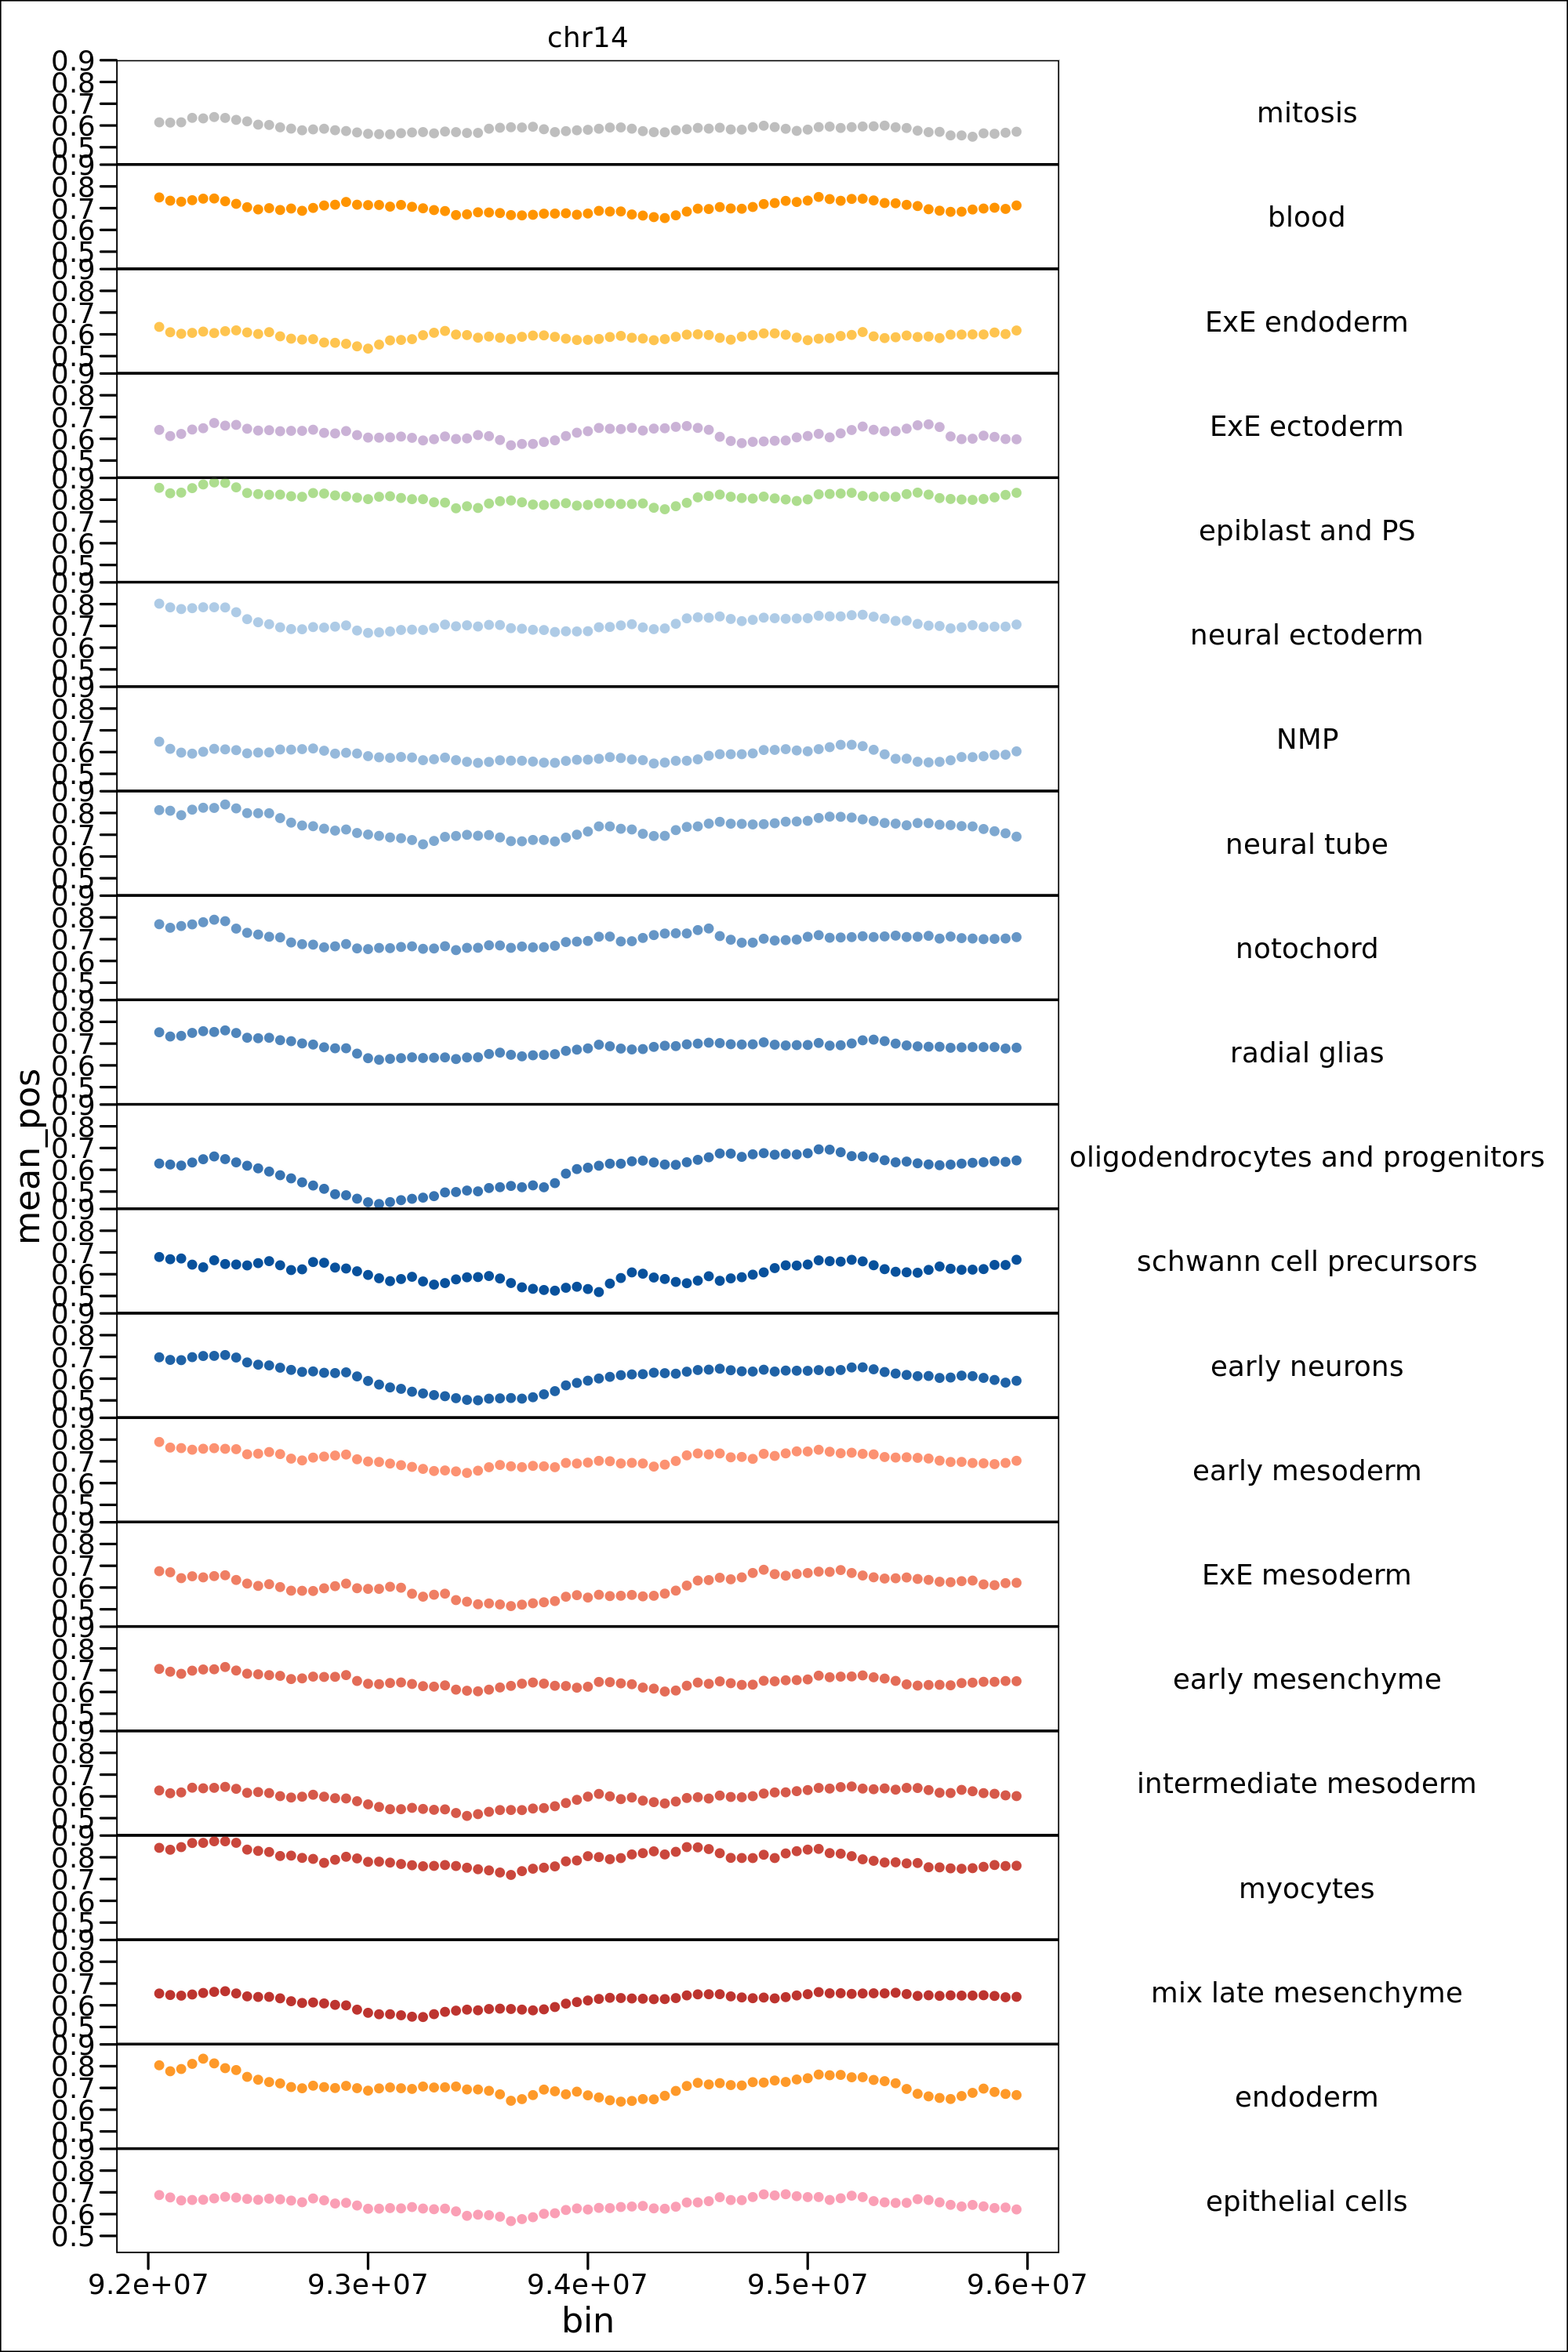

In [99]:
options(repr.plot.width=10, repr.plot.height=15,repr.plot.res=200)
all %>% filter(chrom =="chr14",bin > 92000000,bin < 96000000) %>% ggplot(aes(x=bin,y=mean_pos,color = celltype)) + geom_point() + facet_grid(celltype~chrom,scales = "free_x",space = "free") + 
    theme_base() + 
    theme(#axis.text.x = element_blank(),axis.text.y = element_blank(),
    #axis.ticks.x = element_blank(),
    #axis.ticks.y = element_blank(), 
                        panel.spacing=unit(0,"lines"),
    strip.text.y = element_text(angle = 0)) + scale_colour_manual(name="",  values =celltypeColors) + NoLegend()

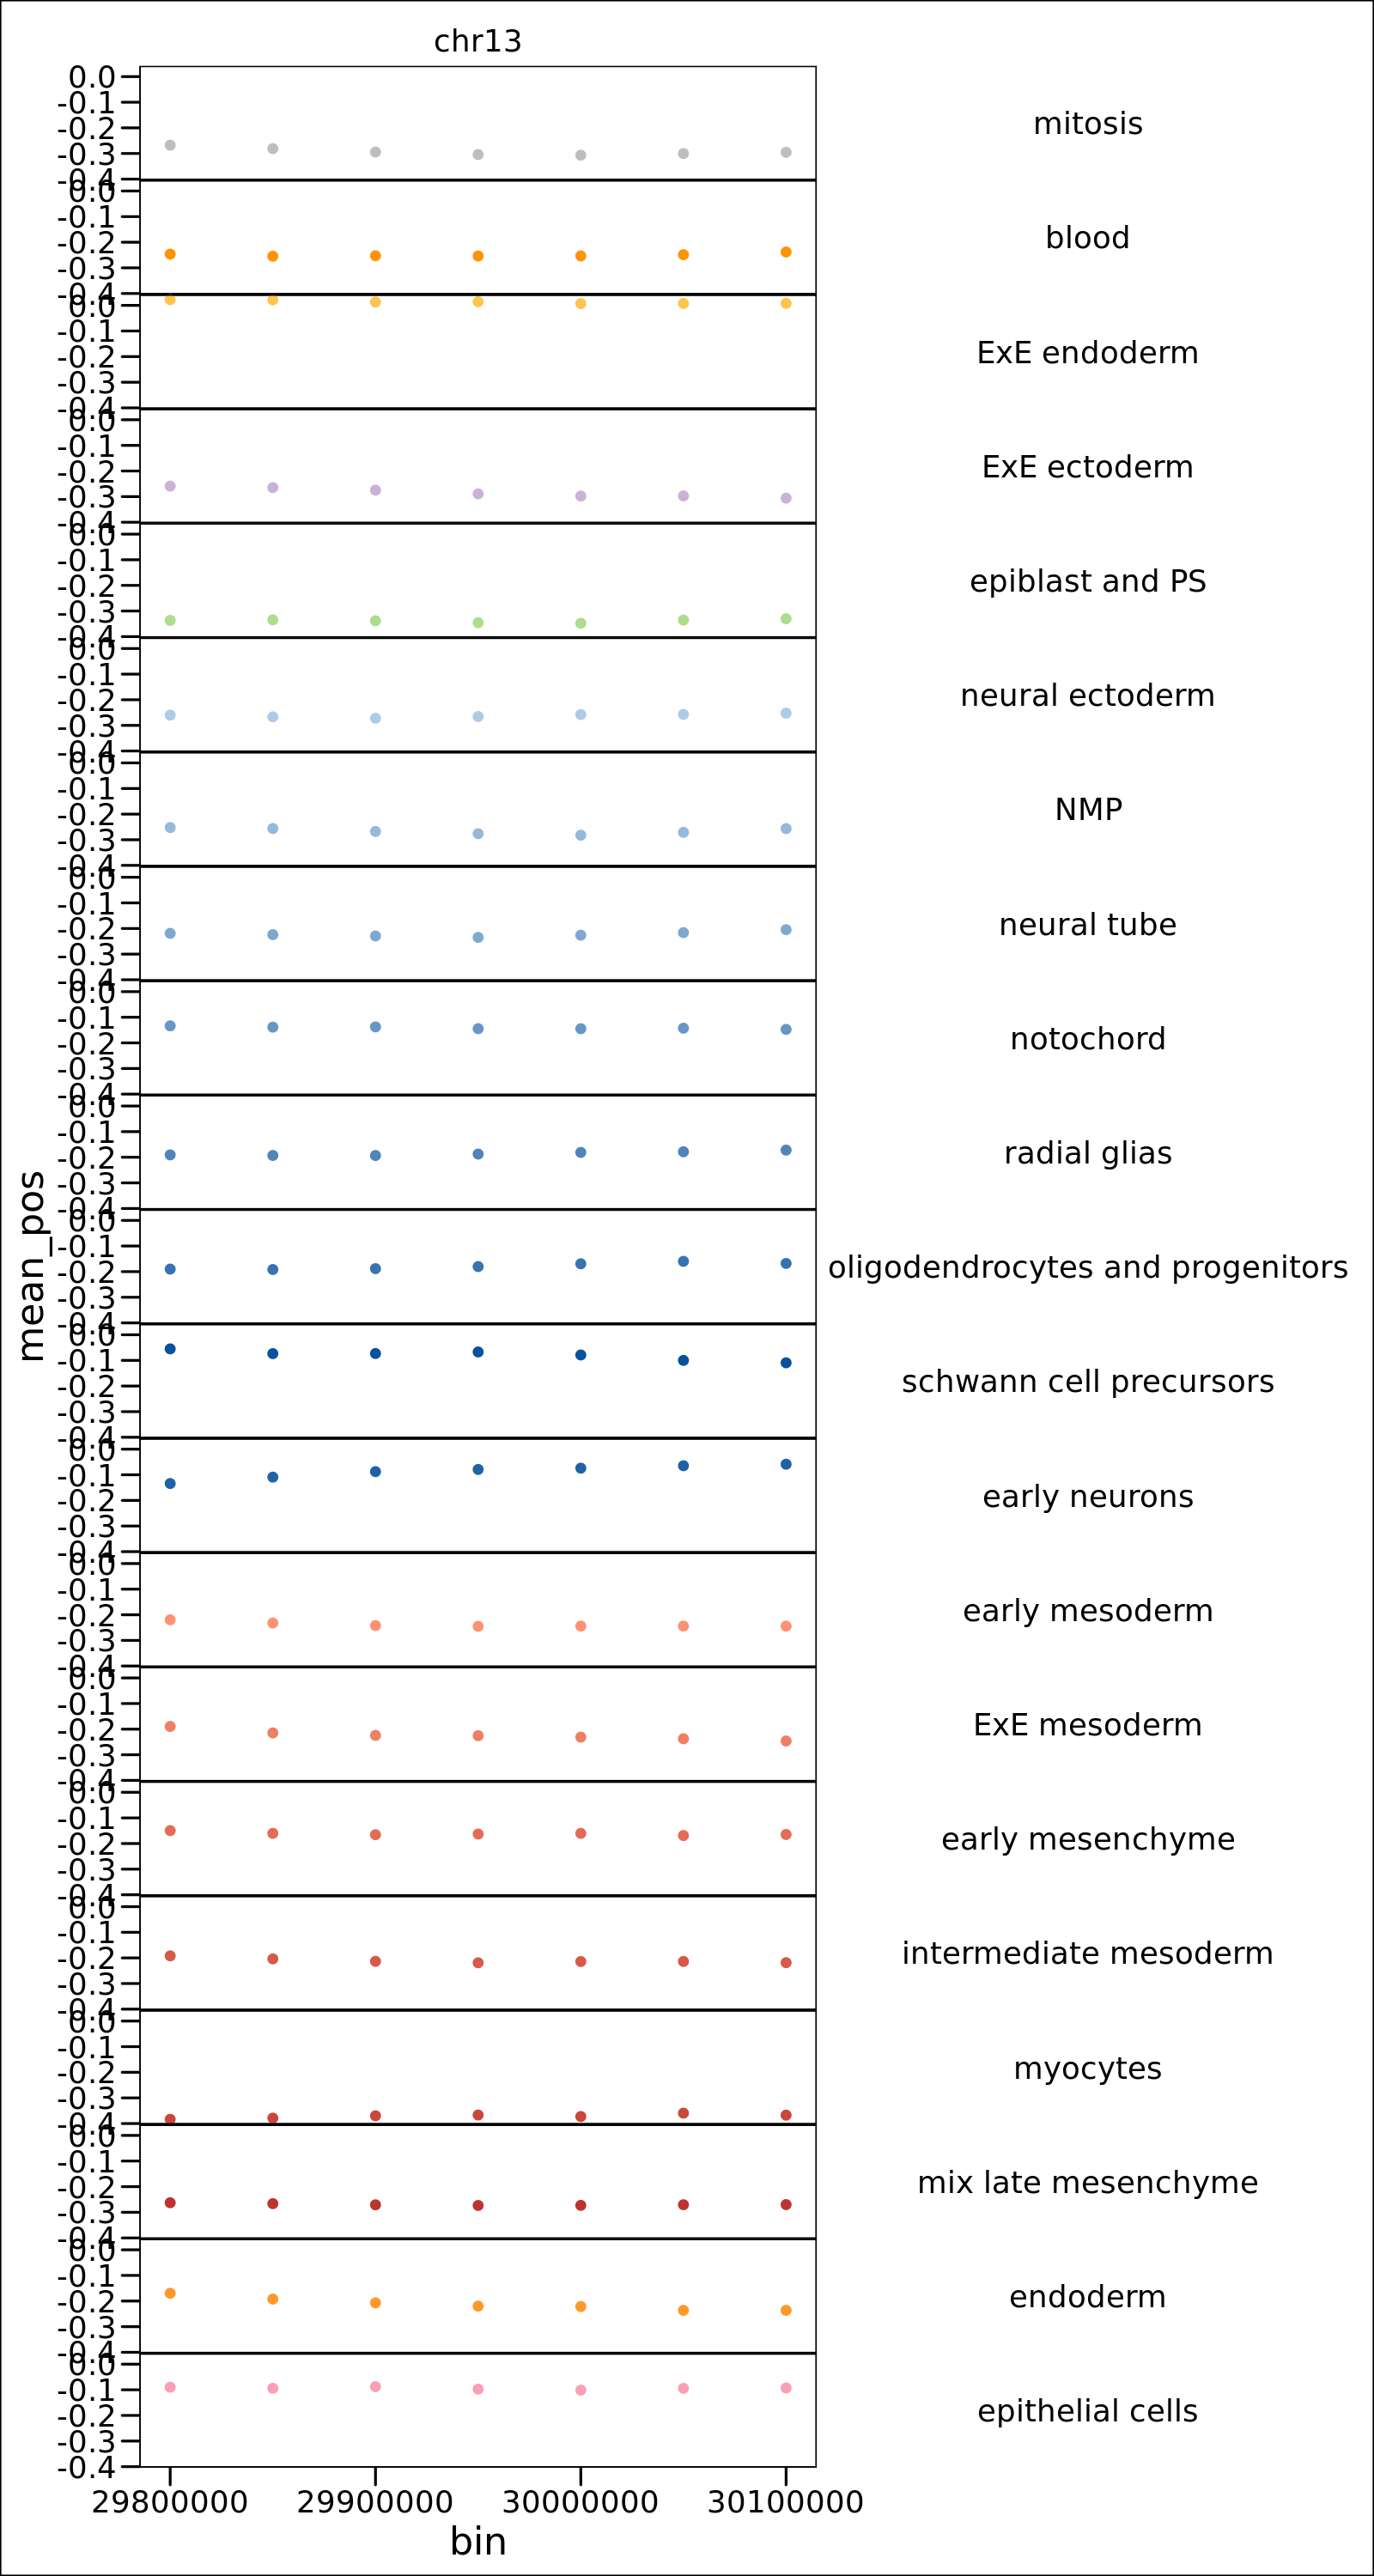

In [100]:

options(repr.plot.width=8, repr.plot.height=15,repr.plot.res=200)
all %>% filter(chrom =="chr13",bin > 29763229,bin < 30129466) %>% ggplot(aes(x=bin,y=mean_pos,color = celltype)) + geom_point() + facet_grid(celltype~chrom,scales = "free_x",space = "free") + 
    theme_base() + 
    theme(#axis.text.x = element_blank(),axis.text.y = element_blank(),
    #axis.ticks.x = element_blank(),
    #axis.ticks.y = element_blank(), 
                        panel.spacing=unit(0,"lines"),
    strip.text.y = element_text(angle = 0)) + scale_colour_manual(name="",  values =celltypeColors) + NoLegend()

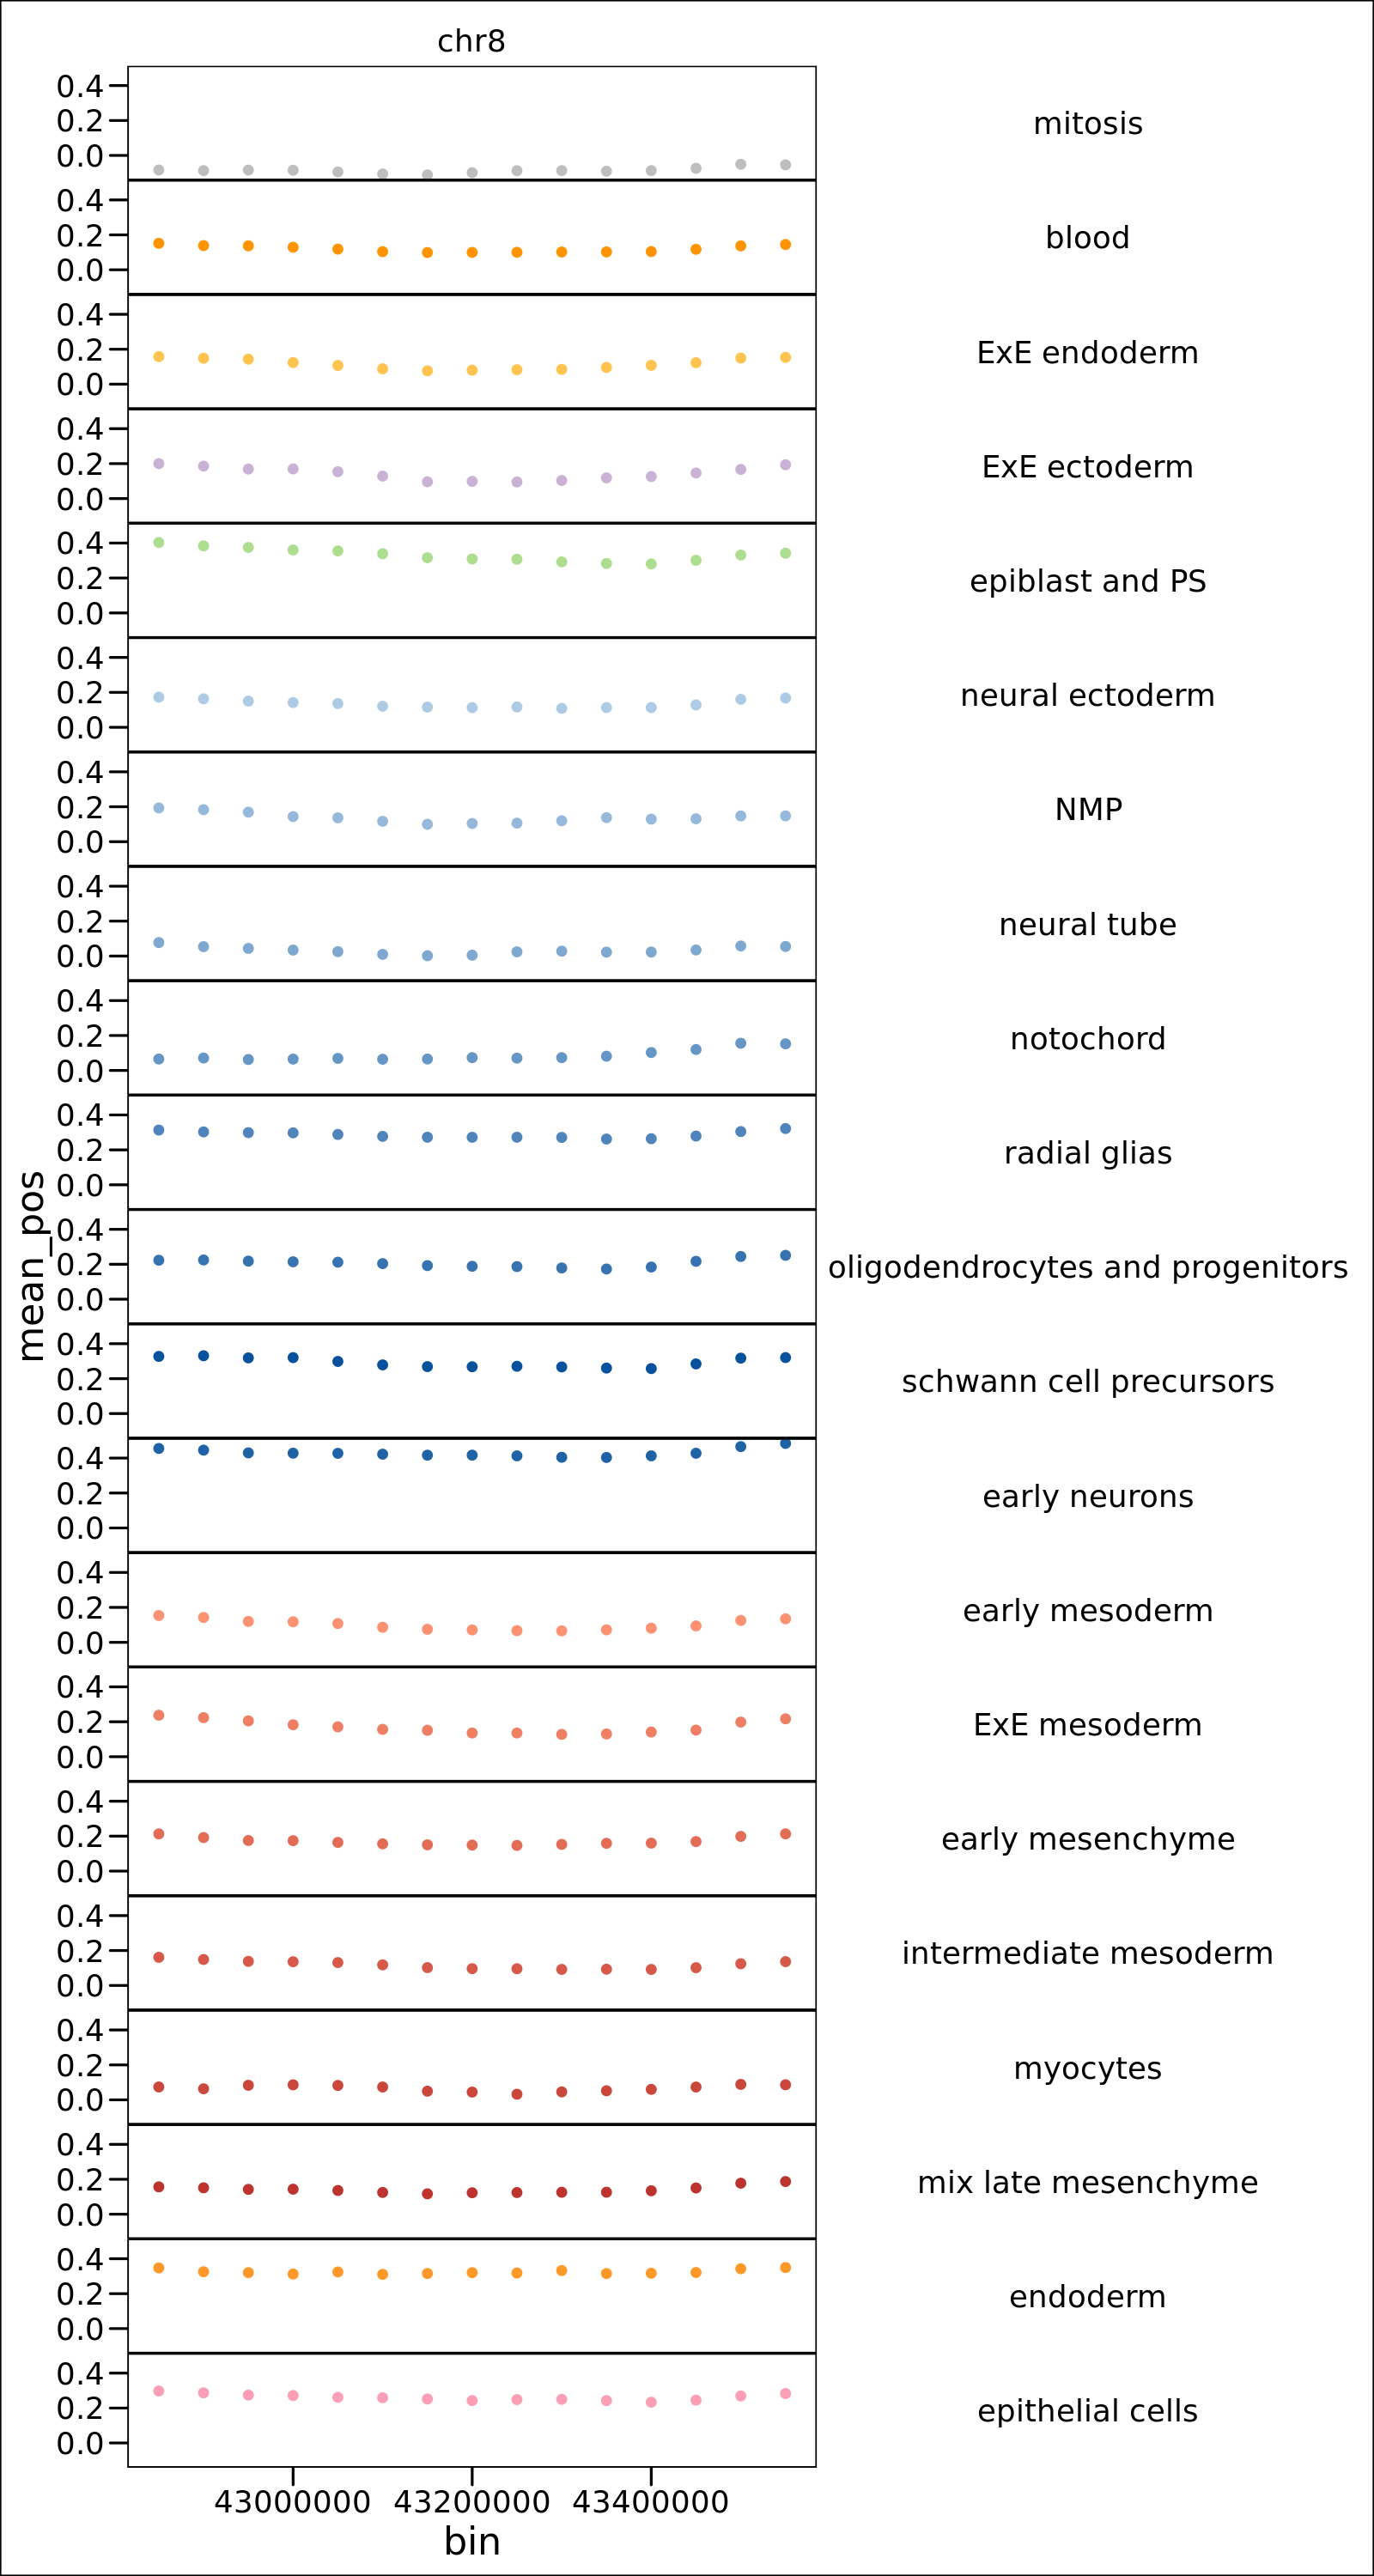

In [101]:
options(repr.plot.width=8, repr.plot.height=15,repr.plot.res=200)
all %>% filter(chrom =="chr8",bin > 42830574,bin < 43586617) %>% ggplot(aes(x=bin,y=mean_pos,color = celltype)) + geom_point() + facet_grid(celltype~chrom,scales = "free_x",space = "free") + 
    theme_base() + 
    theme(#axis.text.x = element_blank(),axis.text.y = element_blank(),
    #axis.ticks.x = element_blank(),
    #axis.ticks.y = element_blank(), 
                        panel.spacing=unit(0,"lines"),
    strip.text.y = element_text(angle = 0)) + scale_colour_manual(name="",  values =celltypeColors) + NoLegend()

# pcdh9 example

In [9]:
consider_names <-  c(hires[[]] %>% filter(celltype == "early neurons",rmsd_20k < 1.5) %>% sample_n(100) %>% pull(cellname),
hires[[]] %>% filter(celltype == "epiblast and PS",rmsd_20k < 1.5) %>% sample_n(100) %>% pull(cellname)) #%>% as.data.frame() 

In [10]:
color_paths <- paste0("/shareb/zliu/analysis/hires_mouse_dev/HiC_clean3/3d_info/radialPos/",consider_names,".rp.20k.0.color")
parseRadPos <- function(filename){
    temp <- read_table(filename,col_types = cols(),col_names = c("chr","bin","pos")) %>% mutate(cellname = str_extract(filename,"[GO][A-Za-z]+[0-9]+"), rep = strsplit(filename,".",fixed=TRUE)[[1]][5])
    return(temp)
}
res <- map(color_paths,parseRadPos) %>% bind_rows()

In [13]:
res <- res %>% group_by(cellname) %>% mutate(pos_norm = pos/mean(pos))
data <- res %>% left_join(hires[[]] %>% select(cellname,celltype)) %>% group_by(celltype,chr,bin) %>% summarise(mean_pos = mean(pos_norm))

# exclude chrom XY 
all <- data %>% mutate(chrom = str_extract(chr,pattern = "chr[0-9]+")) %>% group_by(celltype,chrom,bin) %>% summarise(mean_pos = mean(mean_pos)) %>% na.omit()
all$chrom <- factor(all$chrom, levels = paste0("chr",seq(1:19)))
all$celltype <- factor(all$celltype, levels =names(celltypeColors))

Joining, by = "cellname"
`summarise()` has grouped output by 'celltype', 'chr'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'celltype', 'chrom'. You can override using the `.groups` argument.


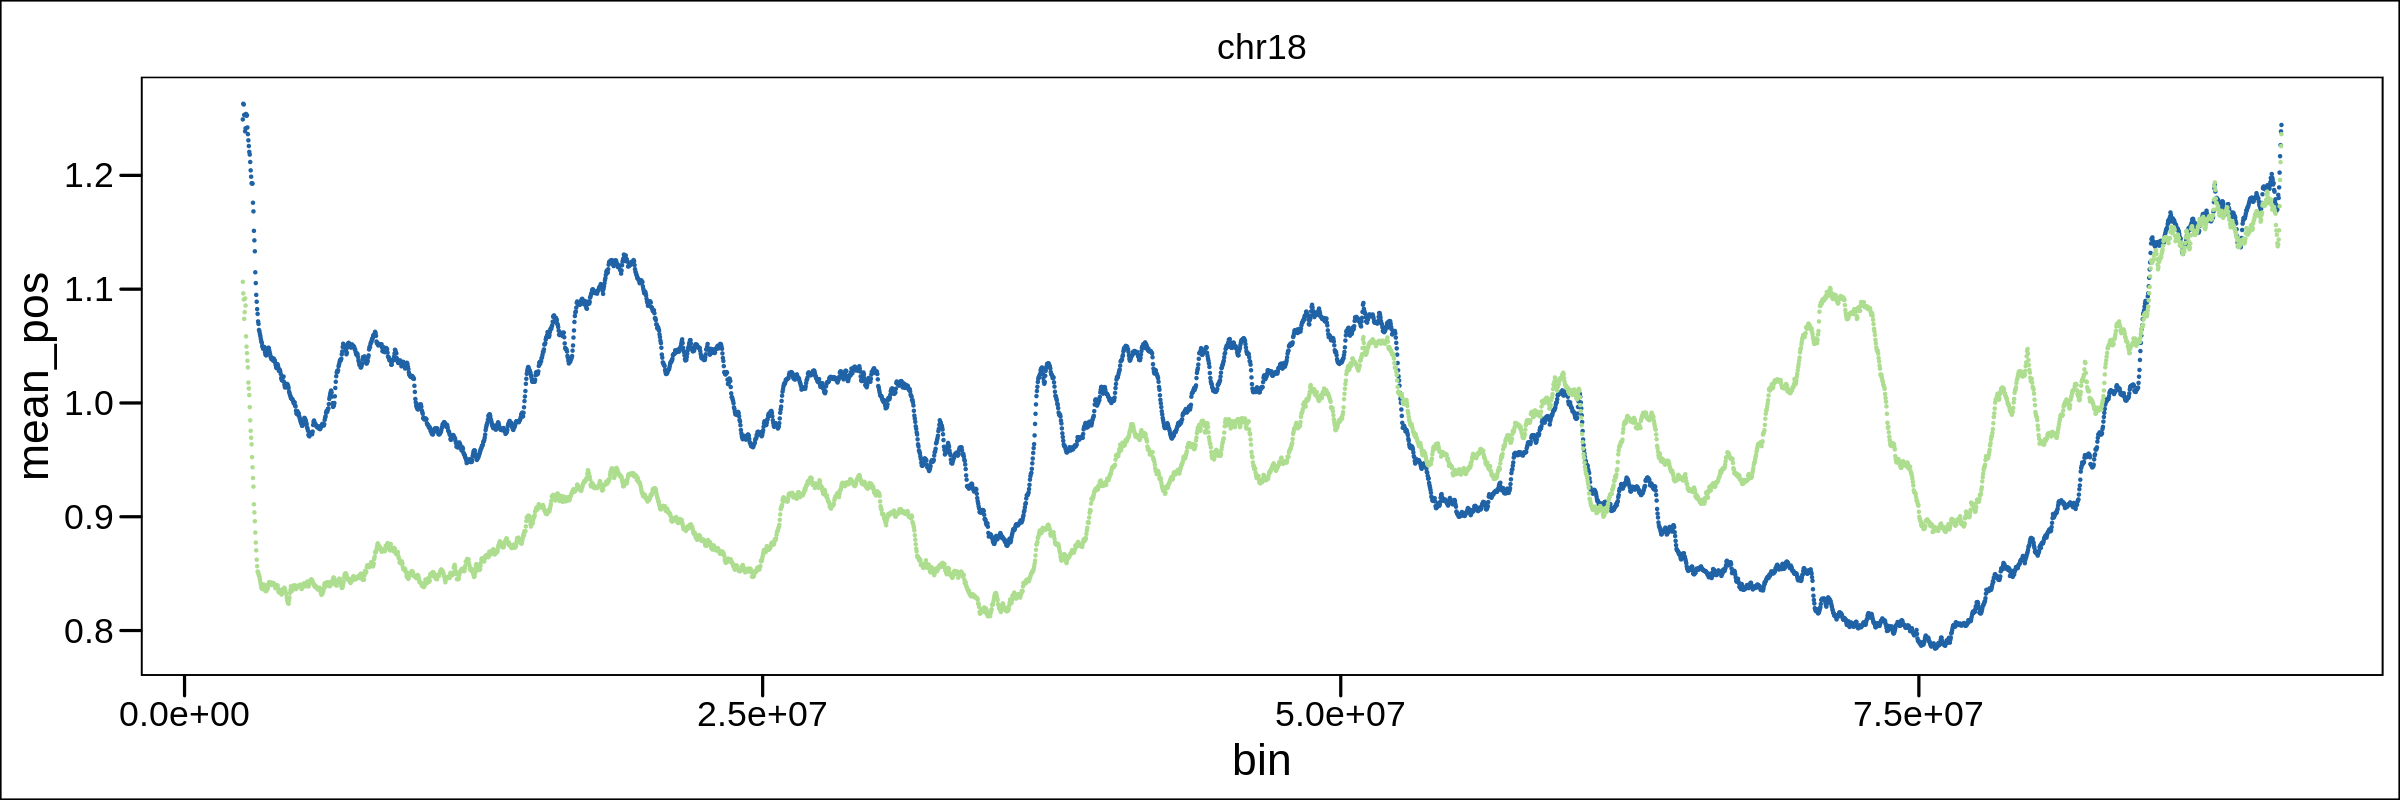

In [14]:
options(repr.plot.width=12, repr.plot.height=4,repr.plot.res=200)
all %>% filter(chrom =="chr18") %>% ggplot(aes(x=bin,y=mean_pos,color = celltype)) + geom_point(size=0.1) + facet_grid(~chrom,scales = "free_x",space = "free") + 
    theme_base() + 
    theme(#axis.text.x = element_blank(),axis.text.y = element_blank(),
    #axis.ticks.x = element_blank(),
    #axis.ticks.y = element_blank(), 
                        panel.spacing=unit(0,"lines"),
    strip.text.y = element_text(angle = 0)) + scale_colour_manual(name="",  values =celltypeColors) + NoLegend()

In [ ]:
options(repr.plot.width=12, repr.plot.height=4,repr.plot.res=200)
all %>% filter(chrom =="chr18") %>% ggplot(aes(x=bin,y=mean_pos,color = celltype)) + geom_point(size=0.1) + facet_grid(~chrom,scales = "free_x",space = "free") + 
    theme_base() + 
    theme(#axis.text.x = element_blank(),axis.text.y = element_blank(),
    #axis.ticks.x = element_blank(),
    #axis.ticks.y = element_blank(), 
                        panel.spacing=unit(0,"lines"),
    strip.text.y = element_text(angle = 0)) + scale_colour_manual(name="",  values =celltypeColors) + NoLegend()

In [ ]:
options(repr.plot.width=6, repr.plot.height=4,repr.plot.res=200)
all %>% filter(chrom =="chr14",bin > 90000000,bin < 100000000) %>% ggplot(aes(x=bin,y=mean_pos,color = celltype)) + geom_point() + facet_grid(~chrom,scales = "free_x",space = "free") + 
    theme_base() + 
    theme(#axis.text.x = element_blank(),axis.text.y = element_blank(),
    #axis.ticks.x = element_blank(),
    #axis.ticks.y = element_blank(), 
                        panel.spacing=unit(0,"lines"),
    strip.text.y = element_text(angle = 0)) + scale_colour_manual(name="",  values =celltypeColors) + NoLegend()

In [28]:
res <- res %>% group_by(cellname) %>% mutate(pos_norm = pos)
data <- res %>% left_join(hires[[]] %>% select(cellname,celltype)) %>% group_by(celltype,chr,bin) %>% summarise(mean_pos = mean(pos_norm))

# exclude chrom XY 
all <- data %>% mutate(chrom = str_extract(chr,pattern = "chr[0-9]+")) %>% group_by(celltype,chrom,bin) %>% summarise(mean_pos = mean(mean_pos)) %>% na.omit()
all$chrom <- factor(all$chrom, levels = paste0("chr",seq(1:19)))
all$celltype <- factor(all$celltype, levels =names(celltypeColors))

Joining, by = "cellname"
`summarise()` has grouped output by 'celltype', 'chr'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'celltype', 'chrom'. You can override using the `.groups` argument.


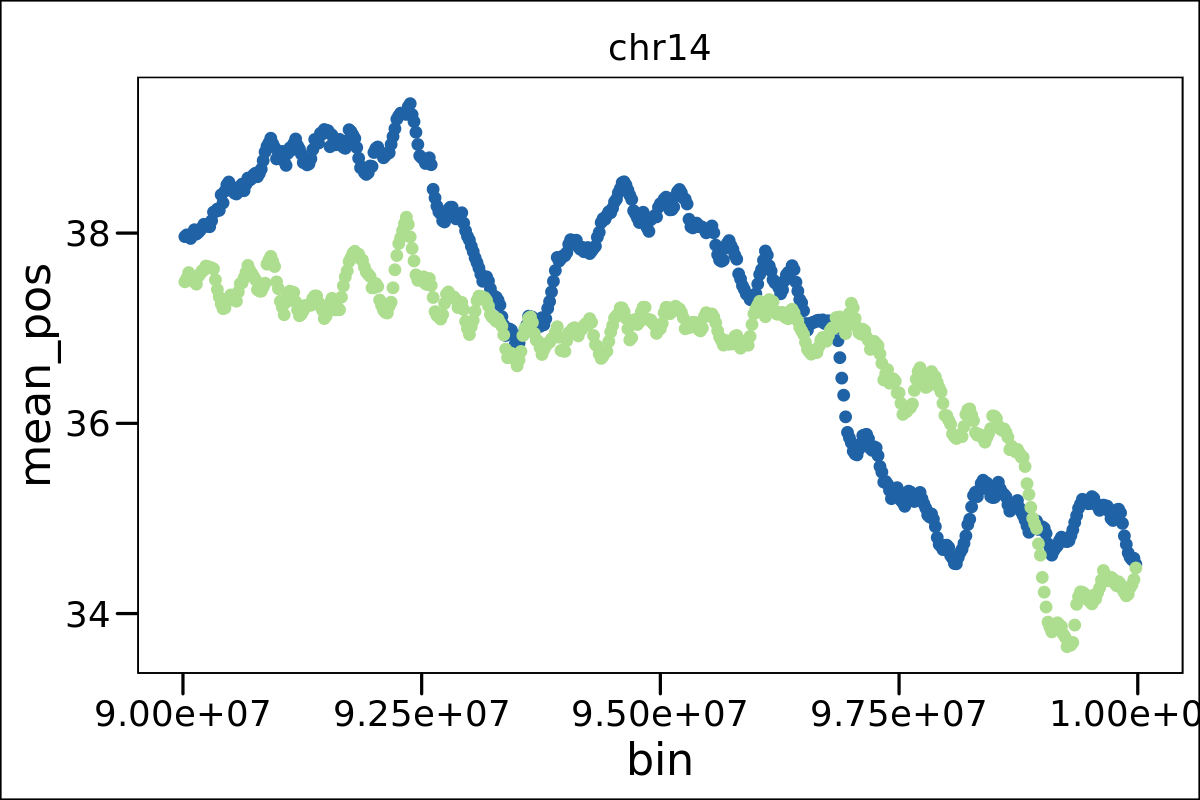

In [29]:
options(repr.plot.width=6, repr.plot.height=4,repr.plot.res=200)
all %>% filter(chrom =="chr14",bin > 90000000,bin < 100000000) %>% ggplot(aes(x=bin,y=mean_pos,color = celltype)) + geom_point() + facet_grid(~chrom,scales = "free_x",space = "free") + 
    theme_base() + 
    theme(#axis.text.x = element_blank(),axis.text.y = element_blank(),
    #axis.ticks.x = element_blank(),
    #axis.ticks.y = element_blank(), 
                        panel.spacing=unit(0,"lines"),
    strip.text.y = element_text(angle = 0)) + scale_colour_manual(name="",  values =celltypeColors) + NoLegend()